<a href="https://colab.research.google.com/github/ChowWigglePuff/cap-comp215/blob/Main/Project_Schelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Project 2: Shelling's model of Segregation**

I will be basing my project off of the week 12 lesson "Shelling's Agent-Based model of Segregation". I intend to modify the code such that I can experiment with the parameters and be able to compare it with the model provided in the lesson. A big portion of the code here will be taken from the week 12 lesson.


My goals for this project is to see how much multiple colours will affect the time it takes to reach steady state, and to see how the p value would affect it as well.


Module imports to use

In [166]:
%matplotlib inline

import random
import time

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.signal import correlate2d

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

# **Helpers**

Taken from the week 12 lesson

In [167]:
# Define a colour map for black, red, blue.
cmap = ['k', 'r', 'b']
shellings_colour_map = matplotlib.colors.ListedColormap(cmap)
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap = shellings_colour_map,
    interpolation='none',
    origin='upper',
)

def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()   # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

In [168]:
def legend(axes=None, **options):
    """Draws a legend only if there is at least one labeled data series.

    :param axes: the axes to add the legend to, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.legend()`
           see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.legend.html
    """
    options = { **dict(loc="best", frameon=False), **options}

    ax = axes or plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, **options)


In [169]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step*self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

# **Schelling's model**

Week 12's lesson's refactored implementation of the Schelling model

In [170]:
class Schelling:
    """A grid of Schelling agents and the rules to simulate Schelling's model with them."""

    # The "types" of Agent "living" in each cell.
    EMPTY = 0
    RED = 1
    BLUE = 2

    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8)

    def __init__(self, n, p, proportion_empty=0.1):
        """
        :param n: grid size:  n X n
        :param p: tolerance threshold - Agents with fraction of similar neighbors < p will move
        :param proportion_empty: the approx. proportion of the grid that are empty cells.
        """
        self.p = p

        proportion_per_agent_type = (1 - proportion_empty) / 2  # distribute remainder among agent types
        probs = [proportion_empty, proportion_per_agent_type, proportion_per_agent_type]
        self.state = np.random.choice([self.EMPTY, self.RED, self.BLUE], (n, n), p=probs)

    def occupied_neighbours_count(self, occupied):
        """
        Return int array, sized same as occupied,
            with a count of number of occupied neighbours for occupied cells.

        :param occupied: a boolean or 0/1 valued array where 1 is considered "occupied"
        Only occupied cells will have a neighborhood count, empty cells have a count of zero.
        """
        neighbour_count = correlate2d(occupied, self.kernel, mode='same', boundary='wrap')
        # Zero out unoccupied cells so we only return neighbourhood counts for occupied cells
        return neighbour_count * occupied # Note: `*` with bool array is an 'and' operation

    def fraction_neighbours_similar(self):
        """
        Return float array, sized same as state,
           with the fraction of neighbours that share a cell's value, or 0 for cells with no neighbours
        """
        num_red = self.occupied_neighbours_count(self.state == self.RED)
        num_blue = self.occupied_neighbours_count(self.state == self.BLUE)
        neighbour_count = self.occupied_neighbours_count(self.state != self.EMPTY)
        # ignore divide-by-zero during the division, then fix it up...
        #   where the neighbour count is zero (e.g. empty cells), arbitrarily set the fraction to zero
        with np.errstate(invalid='ignore'):
            fraction = (num_red + num_blue) / neighbour_count
            return np.where(neighbour_count==0, 0, fraction)

    def segregation(self):
        """ Return the average fraction of similar neighbors, averaged over entire grid. """
        return np.mean(self.fraction_neighbours_similar())

    def move_agents(self, agents):
        """
        Move all the given agents to empty cells in the grid, leaving their cells empty in return

        :param agents: array, same shape as self.state, with agents that are looking for a new home
        """
        # Shuffle the moving agents and the empty cells into a single, randomized vector
        n_empty = np.sum(self.state == self.EMPTY)
        n_red = np.sum(agents == self.RED)
        n_blue = np.sum(agents == self.BLUE)
        moving = np.concatenate((
            np.ones(n_empty) * self.EMPTY,
            np.ones(n_red) * self.RED,
            np.ones(n_blue) * self.BLUE
        ))
        np.random.shuffle(moving)

        # they all pack up and leave...
        self.state[agents!=self.EMPTY] = self.EMPTY
        # ... and we assign them a new home
        self.state[self.state==self.EMPTY] = moving

    def step(self):
        """
        Execute one model time step.

        returns: current segregation value, i.e., the fraction of similar neighbors, averaged over entire grid
        """
        # boolean mask for unhappy agents, where the % similar neighbours is too low
        below_threshold = self.fraction_neighbours_similar() < self.p

        # mask out the unhappy agents and move them to empty cells
        unhappy_agents = self.state * below_threshold  # `*` with boolean acts like `and` operator
        self.move_agents(unhappy_agents)

        # return the new segregation value (average fraction of similar neighbours)
        return self.segregation()

    def draw(self, axes=None, step=''):
        """Draws the cells on given axes."""
        axes = axes or plt.gca()  # use current axes if none are provided.
        plot_2D_array(self.state, axes,  title=f'Shelling @ step {step}')

Using the same example to double check if everything is working properly

0.4587261904761904

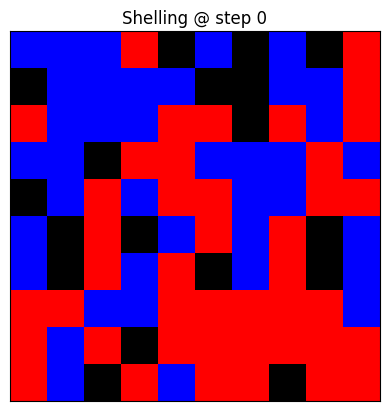

In [171]:
model = Schelling(n=10, p=0.3)
model.draw(step=0)
model.segregation()

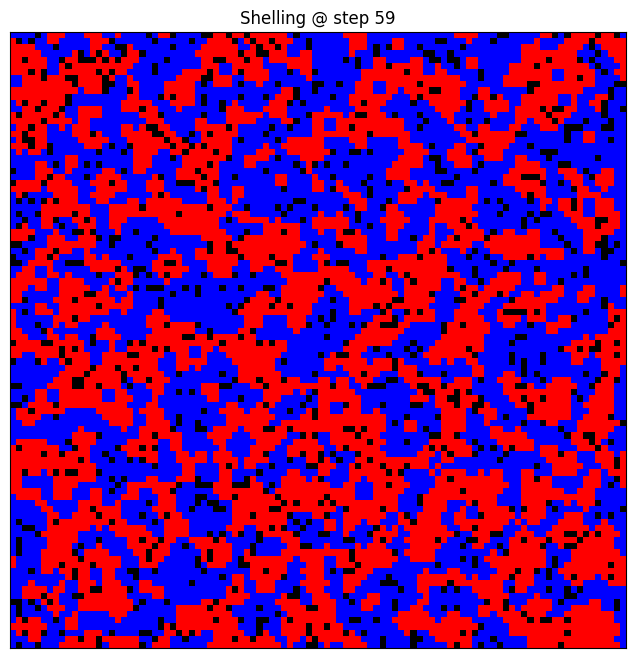

In [172]:
model = Schelling(n=100, p=0.3)
anime1 = Animation2D(model, frames=60)
anime1.animate()

Now, I will make my modify and make a new class so that the model can take in multiple types of Agents living in each cell

In [173]:
# Making a new colour map for my own experiements

# Most of the code is the same as the above, just adding new variable to make it my own

#I realized afterwards, this is so that my animation models have the right correlating colours,
#in the timestep graphs, it does not matter which colours they are, as long as they are different

# Define a colour map for black, red, blue, yellow, green
cmap = ['k', 'r', 'b', 'y', 'g']
myshellings_colour_map = matplotlib.colors.ListedColormap(cmap)
myDEFAULT_IMSHOW_OPTIONS = dict(
    cmap = myshellings_colour_map,
    interpolation='none',
    origin='upper',
)

def my_plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()   # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**myDEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

The other helpers don't need modification as they will be able to server thier own function.

Now I make my own schelling class.

Once again, the majority of the code is taken from the week 12 lesson.

In [174]:
class mySchelling:
  """A grid of schelling agents and the rules to simulate Schelling's model with them; my version"""

  EMPTY = 0
  RED = 1
  BLUE = 2
  YELLOW = 3
  GREEN = 4

  kernel = np.array([[1, 1, 1],
                     [1, 0, 1],
                     [1, 1, 1]], dtype=np.int8)

  def __init__(self, n, p, proportion_empty=0.2):
    """
    :param n: grid size:  n X n
    :param p: tolerance threshold - Agents with fraction of similar neighbors < p will move
    :param proportion_empty: the approx. proportion of the grid that are empty cells.
    """
    self.p = p

    proportion_per_agent_type = (1 - proportion_empty) / 4  # distribute remainder among agent types
    probs = [proportion_empty, proportion_per_agent_type, proportion_per_agent_type, proportion_per_agent_type, proportion_per_agent_type]
    self.state = np.random.choice([self.EMPTY, self.RED, self.BLUE, self.YELLOW, self.GREEN], (n, n), p=probs)

  def occupied_neighbours_count(self, occupied):
    """
    Return an int array, sized same as occupied, with the count of number of occupied neighbours for occupied cells.
    :param occupied: a boolean or 0/1 valued array where 1 is considered "occupied"
    Only occupied cells with have a neighbourhood count, empty cells have a count of zero.
    """
    neighbour_count = correlate2d(occupied, self.kernel, mode='same', boundary='wrap')
    # Zero out unoccupied cells so we only return neighbourhood counts for occupied cells
    return neighbour_count * occupied # Note: `*` with bool array is an 'and' operation

  def fraction_neighbours_similar(self):
    """
    Return float array, sized same as state, with the fraction of neighbours that share a cell's value, or 0 for cells with no neighbours
    This is where I need to make sure adding more colours/agents will still keep the class working.
    """
    num_red = self.occupied_neighbours_count(self.state == self.RED)
    num_blue = self.occupied_neighbours_count(self.state == self.BLUE)
    num_yellow = self.occupied_neighbours_count(self.state == self.YELLOW)
    num_green = self.occupied_neighbours_count(self.state == self.GREEN)
    neighbour_count = self.occupied_neighbours_count(self.state != self.EMPTY)

    with np.errstate(invalid='ignore'):
      fraction = (num_red + num_blue + num_yellow + num_green) / neighbour_count
      return np.where(neighbour_count==0, 0, fraction)

  def segregation(self):
    """ Return the average fraction of similar neighbors, averaged over entire grid. """
    return np.mean(self.fraction_neighbours_similar())

  def move_agents(self, agents):
    """
    Move all the given agents to empty cells in the grid, leaving their cells empty in return

    :param agents: array, same shape as self.state, with agents that are looking for a new home

    Also Modified to make sure the additional colours/agents still works
    """
    # Shuffle the moving agents and the empty cells into a single, randomized vector
    n_empty = np.sum(self.state == self.EMPTY)
    n_red = np.sum(agents == self.RED)
    n_blue = np.sum(agents == self.BLUE)
    n_yellow = np.sum(agents == self.YELLOW)
    n_green = np.sum(agents == self.GREEN)
    moving = np.concatenate((
        np.ones(n_empty) * self.EMPTY,
        np.ones(n_red) * self.RED,
        np.ones(n_blue) * self.BLUE,
        np.ones(n_yellow) * self.YELLOW,
        np.ones(n_green) * self.GREEN
    ))
    np.random.shuffle(moving)

    # they all pack up and leave...
    self.state[agents!=self.EMPTY] = self.EMPTY
    # ... and we assign them a new home
    self.state[self.state==self.EMPTY] = moving


  def step(self):
    """
    Execute one model time step.

    returns: current segregation value, i.e., the fraction of similar neighbors, averaged over entire grid
    """
    # boolean mask for unhappy agents, where the % similar neighbours is too low
    below_threshold = self.fraction_neighbours_similar() < self.p

    # mask out the unhappy agents and move them to empty cells
    unhappy_agents = self.state * below_threshold  # `*` with boolean acts like `and` operator
    self.move_agents(unhappy_agents)

    # return the new segregation value (average fraction of similar neighbours)
    return self.segregation()

  def draw(self, axes=None, step=''):
    """Draws the cells on given axes."""
    axes = axes or plt.gca()
    my_plot_2D_array(self.state, axes, title=f'my Shelling @step {step}')


Testing if the modified class works with an example

0.15989285714285714

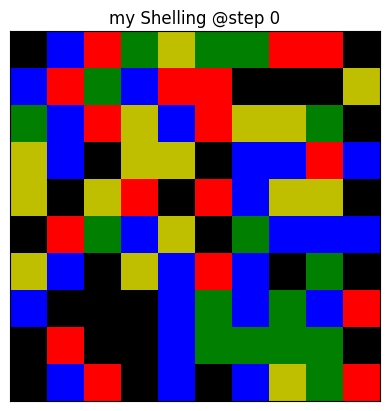

In [175]:
mymodel = mySchelling(n=10, p=0.3)
mymodel.draw(step=0)
mymodel.segregation()

Now that we see that it works, lets make an animation with a bigger example

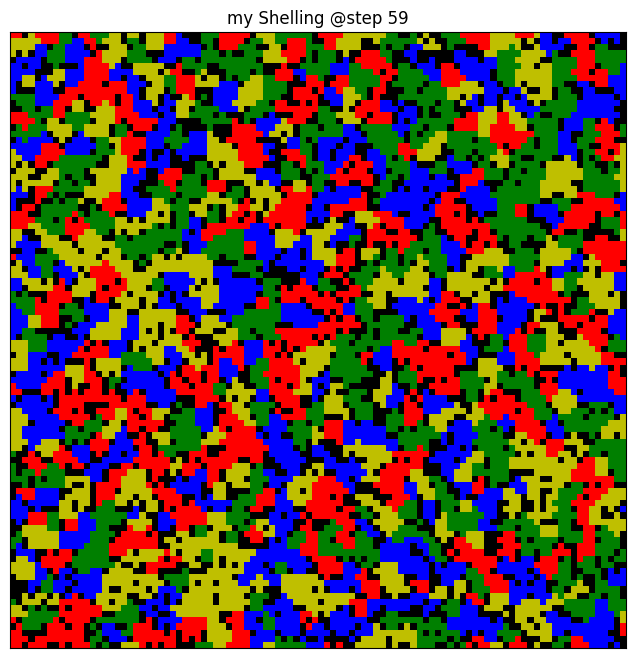

In [176]:
model2 = mySchelling(n=100, p=0.3)
anime2 = Animation2D(model2, frames=60)
anime2.animate()

Now lets try just having 3 colours!

We will have to make another new class that uses 3 colours. The code is still based off of the code from week 12's lesson.


In [177]:
class mySchelling2:
  """A grid of schelling agents and the rules to simulate Schelling's model with them; my version"""

  EMPTY = 0
  RED = 1
  BLUE = 2
  YELLOW = 3

  kernel = np.array([[1, 1, 1],
                     [1, 0, 1],
                     [1, 1, 1]], dtype=np.int8)

  def __init__(self, n, p, proportion_empty=0.1):
    """
    :param n: grid size:  n X n
    :param p: tolerance threshold - Agents with fraction of similar neighbors < p will move
    :param proportion_empty: the approx. proportion of the grid that are empty cells.
    """
    self.p = p

    proportion_per_agent_type = (1 - proportion_empty) / 3  # distribute remainder among agent types
    probs = [proportion_empty, proportion_per_agent_type, proportion_per_agent_type, proportion_per_agent_type]
    self.state = np.random.choice([self.EMPTY, self.RED, self.BLUE, self.YELLOW], (n, n), p=probs)

  def occupied_neighbours_count(self, occupied):
    """
    Return an int array, sized same as occupied, with the count of number of occupied neighbours for occupied cells.
    :param occupied: a boolean or 0/1 valued array where 1 is considered "occupied"
    Only occupied cells with have a neighbourhood count, empty cells have a count of zero.
    """
    neighbour_count = correlate2d(occupied, self.kernel, mode='same', boundary='wrap')
    # Zero out unoccupied cells so we only return neighbourhood counts for occupied cells
    return neighbour_count * occupied # Note: `*` with bool array is an 'and' operation

  def fraction_neighbours_similar(self):
    """
    Return float array, sized same as state, with the fraction of neighbours that share a cell's value, or 0 for cells with no neighbours
    This is where I need to make sure adding more colours/agents will still keep the class working.
    """
    num_red = self.occupied_neighbours_count(self.state == self.RED)
    num_blue = self.occupied_neighbours_count(self.state == self.BLUE)
    num_yellow = self.occupied_neighbours_count(self.state == self.YELLOW)
    neighbour_count = self.occupied_neighbours_count(self.state != self.EMPTY)

    with np.errstate(invalid='ignore'):
      fraction = (num_red + num_blue + num_yellow) / neighbour_count
      return np.where(neighbour_count==0, 0, fraction)

  def segregation(self):
    """ Return the average fraction of similar neighbors, averaged over entire grid. """
    return np.mean(self.fraction_neighbours_similar())

  def move_agents(self, agents):
    """
    Move all the given agents to empty cells in the grid, leaving their cells empty in return

    :param agents: array, same shape as self.state, with agents that are looking for a new home

    Also Modified to make sure the additional colours/agents still works
    """
    # Shuffle the moving agents and the empty cells into a single, randomized vector
    n_empty = np.sum(self.state == self.EMPTY)
    n_red = np.sum(agents == self.RED)
    n_blue = np.sum(agents == self.BLUE)
    n_yellow = np.sum(agents == self.YELLOW)
    moving = np.concatenate((
        np.ones(n_empty) * self.EMPTY,
        np.ones(n_red) * self.RED,
        np.ones(n_blue) * self.BLUE,
        np.ones(n_yellow) * self.YELLOW
    ))
    np.random.shuffle(moving)

    # they all pack up and leave...
    self.state[agents!=self.EMPTY] = self.EMPTY
    # ... and we assign them a new home
    self.state[self.state==self.EMPTY] = moving


  def step(self):
    """
    Execute one model time step.

    returns: current segregation value, i.e., the fraction of similar neighbors, averaged over entire grid
    """
    # boolean mask for unhappy agents, where the % similar neighbours is too low
    below_threshold = self.fraction_neighbours_similar() < self.p

    # mask out the unhappy agents and move them to empty cells
    unhappy_agents = self.state * below_threshold  # `*` with boolean acts like `and` operator
    self.move_agents(unhappy_agents)

    # return the new segregation value (average fraction of similar neighbours)
    return self.segregation()

  def draw(self, axes=None, step=''):
    """Draws the cells on given axes."""
    axes = axes or plt.gca()
    my2_plot_2D_array(self.state, axes, title=f'my Shelling @step {step}')

cmap = ['k', 'r', 'b', 'y']
my2shellings_colour_map = matplotlib.colors.ListedColormap(cmap)
my2DEFAULT_IMSHOW_OPTIONS = dict(
    cmap = my2shellings_colour_map,
    interpolation='none',
    origin='upper',
)

def my2_plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()   # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**my2DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

Lets test this one out

0.2666428571428571

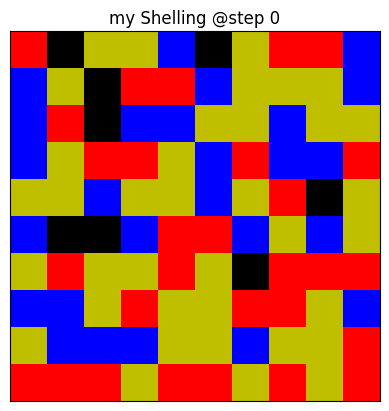

In [178]:
mymodel2 = mySchelling2(n=10, p=0.3)
mymodel2.draw(step=0)
mymodel2.segregation()

And running an animation for it

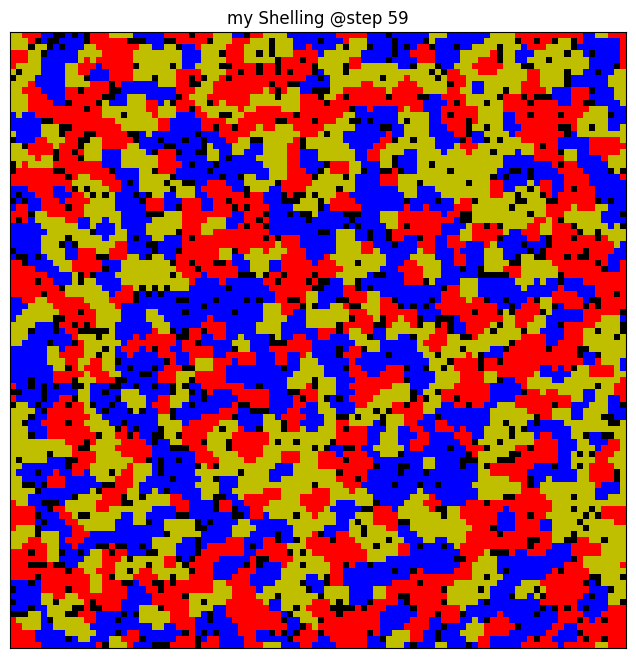

In [179]:
model3 = mySchelling2(n=100, p=0.3)
anime3 = Animation2D(model3, frames=60)
anime3.animate()

Now we see that for both 4 colours and 3 colours, the steady state analysis is achievable. Lets plot that to see the differences

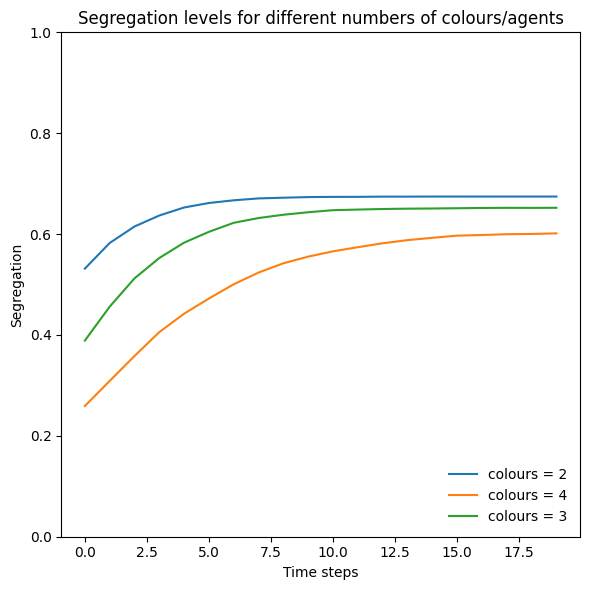

In [180]:
_, ax = plt.subplots(figsize=(6,6), layout='tight')
ax.set(
    title=f'Segregation levels for different numbers of colours/agents',
    xlabel='Time steps',
    ylabel='Segregation',
    ylim=[0, 1]
)

two_c = Schelling(n=100, p=0.3)
four_c = mySchelling(n=100, p=0.3)
three_c = mySchelling2(n=100, p=0.3)


segregation_values = [two_c.step() for i in range (20)]
ax.plot(segregation_values, label= 'colours = 2')
segregation_values = [four_c.step() for i in range (20)]
ax.plot(segregation_values, label= 'colours = 4')
segregation_values = [three_c.step() for i in range (20)]
ax.plot(segregation_values, label= 'colours = 3')

legend(axes=ax, loc='lower right')
plt.show()

As expected, the segregation takes longer to reach a steady state the more colours/agents you have.

Lets try another experiment, this time increasing the "p", the tolerance of how many similar neighbours there has to be until satisfied

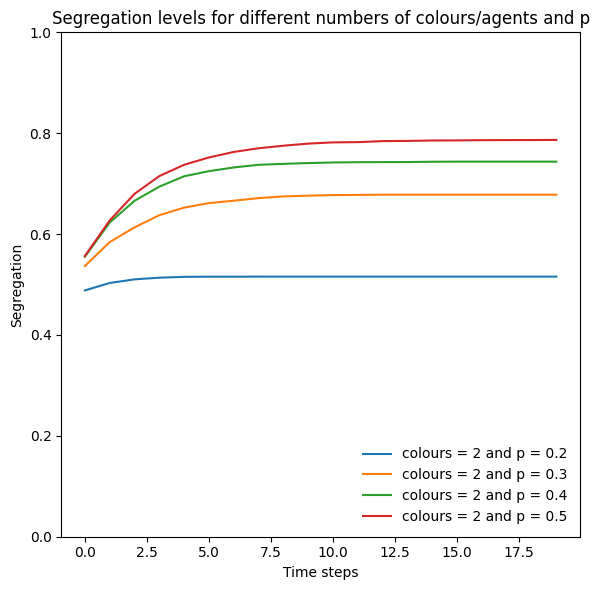

In [181]:
_, ax = plt.subplots(figsize=(6,6), layout='tight')
ax.set(
    title=f'Segregation levels for different numbers of colours/agents and p',
    xlabel='Time steps',
    ylabel='Segregation',
    ylim=[0, 1]
)

for p in [0.2, 0.3, 0.4, 0.5]:
  two_c = Schelling(n=100, p=p)
  segregation_values = [two_c.step() for i in range (20)]
  ax.plot(segregation_values, label= f'colours = 2 and p = {p}')

legend(axes=ax, loc='lower right')
plt.show()

As we can see above, increasing the threshold of p makes it so that it takes a bit longer for the system to reach a steady state.

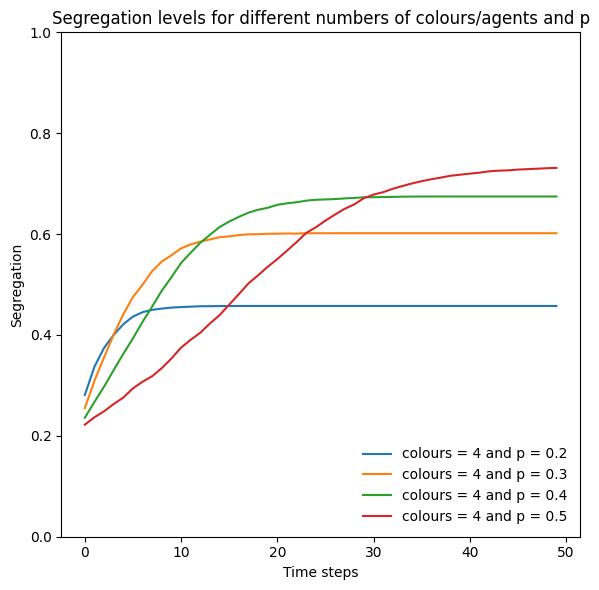

In [182]:
_, ax = plt.subplots(figsize=(6,6), layout='tight')
ax.set(
    title=f'Segregation levels for different numbers of colours/agents and p',
    xlabel='Time steps',
    ylabel='Segregation',
    ylim=[0, 1]
)


for p in [0.2, 0.3, 0.4, 0.5]:
  four_c = mySchelling(n=100, p=p)
  segregation_values = [four_c.step() for i in range (50)]
  ax.plot(segregation_values, label= f'colours = 4 and p = {p}')

legend(axes=ax, loc='lower right')
plt.show()

With 4 colours/agents, it makes sense that the higher the threshold th even longer and slower the system reaches a steady state, as there are more chances to be dissatisfied with the different coloured neighbours.

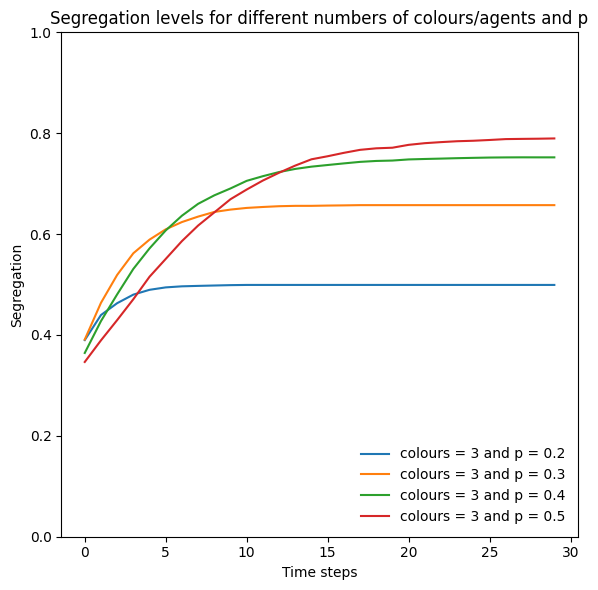

In [183]:
_, ax = plt.subplots(figsize=(6,6), layout='tight')
ax.set(
    title=f'Segregation levels for different numbers of colours/agents and p',
    xlabel='Time steps',
    ylabel='Segregation',
    ylim=[0, 1]
)

for p in [0.2, 0.3, 0.4, 0.5]:
  three_c = mySchelling2(n=100, p=p)
  segregation_values = [three_c.step() for i in range (30)]
  ax.plot(segregation_values, label= f'colours = 3 and p = {p}')

legend(axes=ax, loc='lower right')
plt.show()

The 3 colours sees the same effect but not at the same magnitude as the 4 colours

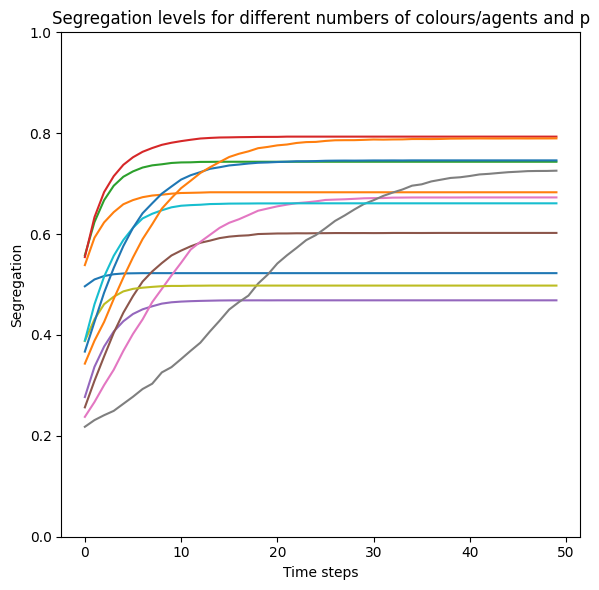

In [184]:
_, ax = plt.subplots(figsize=(6,6), layout='tight')
ax.set(
    title=f'Segregation levels for different numbers of colours/agents and p',
    xlabel='Time steps',
    ylabel='Segregation',
    ylim=[0, 1]
)

for p in [0.2, 0.3, 0.4, 0.5]:
  two_c = Schelling(n=100, p=p)
  segregation_values = [two_c.step() for i in range (50)]
  ax.plot(segregation_values, label= f'colours = 2 and p = {p}')

for p in [0.2, 0.3, 0.4, 0.5]:
  four_c = mySchelling(n=100, p=p)
  segregation_values = [four_c.step() for i in range (50)]
  ax.plot(segregation_values, label= f'colours = 4 and p = {p}')

for p in [0.2, 0.3, 0.4, 0.5]:
  three_c = mySchelling2(n=100, p=p)
  segregation_values = [three_c.step() for i in range (50)]
  ax.plot(segregation_values, label= f'colours = 3 and p = {p}')

#legend(axes=ax, loc='lower right')
plt.show()

And here are all the colour numbers and p values together, to have an easy comparision on how the segregation over timesteps is different.

From analysising the graphs, it seems like increasing the colours pushes the timesteps up for the system to achieve steady state, while increasing the 'p' brings the segregation levels upwards.

It's interesting to see that for any amount of colours, the 'p' still brings the segregation to similar levels:

p = 0.2 ends up in a steady state of around 0.45

p = 0.3 ends up in a steady state of around 0.6

p = 0.4 ends up in a steady state of around 0.7

p = 0.5 ends up in a steady state of around 0.8